In [1]:
import os
import sys
sys.path.append('/home/kevinteng/Desktop/DE_Project')
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from coord_conv import CoordConv
import cv2
import utils
import utils_vis
import utils_model
from sklearn.model_selection import train_test_split
from utils_vis import plot_comparison
from matplotlib.colors import LinearSegmentedColormap, BoundaryNorm
from random import randint, seed
from utils import stack4plot, similarity_multi, similarity_multiplication
from utils_vis import overlapMasks, overlapMasks02

/home/kevinteng/anaconda3/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/kevinteng/anaconda3/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/kevinteng/anaconda3/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/kevinteng/anaconda3/lib/python3.6/site-package

---------------------

# Retrieving and Preprocess Data

Image size:  100


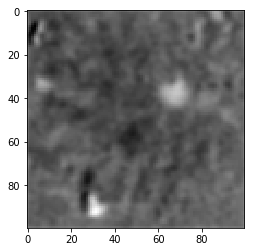

In [2]:
dataset = np.load('/home/kevinteng/Desktop/jpg_to_npy_benchmark/DG13_3-8-17_preprocessed_dF.npy')

#hyperparameter 
NEW_SIZE = 100
ver = 'dummy' #version no.
BATCH_SIZE = 8
lr01 = 0.00001 #learning rate for global 
lr02 = 0.000001 #learning rate for encoder 
lr03 = 0.1 #learning rate for learnable coords
n_neurons = 200
MAX_EPOCHS = 2000
l1_coeff = 0.1
path_desktop = '/home/kevinteng/Desktop/'
#re_list = dataset
re_list = utils.resize(dataset, NEW_SIZE)
IMG_SIZE = re_list.shape[1]

print('Image size: ', IMG_SIZE)
#Dimension for network should include the color channel 
re_list = np.expand_dims(re_list, axis = -1)
#Cast data type to float32 for TensorFlow
# re_list = re_list.astype('float32')
re_list = tf.convert_to_tensor(re_list, dtype = tf.float32)

for img in re_list:
    plt.imshow(np.reshape(img, (IMG_SIZE, IMG_SIZE)), cmap = 'gray')
    plt.show()
    
    break
    
#     if input()=='exit':
#         break

In [3]:
#apply min max norm for mean image
re_list = utils.min_max_norm(re_list)
#max_img_ori = np.expand_dims(max_img_ori, -1)
print('Max value:', np.max(re_list))
print('Min value:', np.min(re_list))


Max value: 1.0
Min value: 0.0


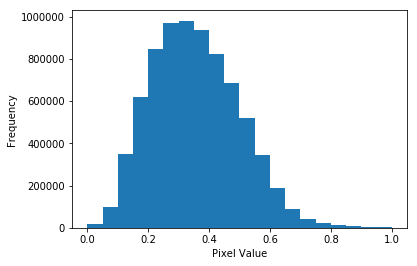

In [4]:
#plot historgram for min max norm image
plt.hist(tf.reshape(re_list, [-1]),20,[0,1])
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.show()

----------------------------------------------------------


# Validation

In [5]:
coords,_, ori_one_hot_imgs = utils_model.create_dat_samples(n_neurons, IMG_SIZE, min_range = 5, 
                                                            max_range = 95, Range = True)
#normalizing 
# coords /= (IMG_SIZE-1)
coords = tf.reshape(coords, [n_neurons, 1,1,2])
tf.print(tf.shape(coords))

[200 1 1 2]


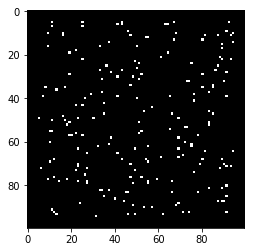

In [6]:
plt.imshow(np.squeeze(np.sum(ori_one_hot_imgs, axis=0)), cmap = 'gray')

-----------------------------------

# Model

In [7]:
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, MaxPooling2D, UpSampling2D
from tensorflow.keras.layers import InputLayer, Conv2DTranspose, Activation, BatchNormalization
from tensorflow.keras.layers import Input, Softmax
from tensorflow.keras.regularizers import l1
from utils_model import conv_block, coordconv_block, up_block, up_coord_block
from tensorflow.keras import layers


def encoder(inps, img_size):
    #downsampling
    coord01 =CoordConv(x_dim = img_size, y_dim = img_size, with_r = False, 
                       filters = 128,strides=(1,1), kernel_size = 3, padding='same'
                       ,activity_regularizer=l1(l1_coeff))(inps)
    act01=tf.keras.layers.ReLU()(coord01)
    pool01=MaxPooling2D((2, 2), strides=2,padding='same')(act01)
    conv01=Conv2D(64, kernel_size = 3, padding='same',activity_regularizer=l1(l1_coeff))(pool01)
    act02=tf.keras.layers.ReLU()(conv01)
    pool02=MaxPooling2D((2, 2), strides=2,padding='same')(act02)
    conv02=Conv2D(32, kernel_size = 3, padding='same',activity_regularizer=l1(l1_coeff))(pool02)
    act03=tf.keras.layers.ReLU()(conv02)
    pool03=MaxPooling2D((2, 2), strides=2,padding='same')(act03)
    
    #upsampling
    x=CoordConv(x_dim = 13, y_dim = 13, with_r = False, 
                filters = 128,strides=(1,1), kernel_size = 3, padding='same',
                activity_regularizer=l1(0.1))(pool03)
    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(64, 3, padding = 'same', activation = 'relu',activity_regularizer=l1(l1_coeff))(x)
    x = UpSampling2D(size=(2,2))(x)
    x = Conv2D(32, 3, padding = 'valid', activation = 'relu',activity_regularizer=l1(l1_coeff))(x)
    x = UpSampling2D(size=(2,2))(x)
    x = Conv2D(16, 3, padding = 'same', activation = 'relu',activity_regularizer=l1(l1_coeff))(x)
    output = Conv2D(1, 3, padding = 'same', activation = 'sigmoid',activity_regularizer=l1(l1_coeff))(x)
    return output


def de_conv(input_tensor):
    coord01 = CoordConv(x_dim = 100, y_dim = 100, with_r = False, filters = 100,
              kernel_size = 1, padding='same', activation='relu')(input_tensor)
    conv01 = Conv2D(filters = 50, kernel_size = 1, strides = 1, padding = "same", activation = 'relu')(coord01)
    conv02 = Conv2D(filters = 50, kernel_size = 1, strides = 1, padding = "same", activation = 'relu')(conv01)
    conv03 = Conv2D(filters = 100, kernel_size = 1, strides = 1, padding = "same", activation = 'relu')(conv02)
    conv04 = Conv2D(filters = 100, kernel_size = 1, strides = 1, padding = "same", activation = 'relu')(conv03)
    conv05 = Conv2D(filters = 1, kernel_size = 1, strides = 1, padding = "same" )(conv04)
    f1 = Flatten()(conv05)
    output = Softmax(axis = -1)(f1)

    return output

def latent_space(encoded_imgs, deconv_imgs, coords, batch_size, img_size):
    '''
    This function construct the dot product of the output of an encoder(batch_size, img_size, img_size, 1) 
    with the one hot images generated by decoord-conv(n_neurons, img_size, img_size, 1), which yields
    similarity score (batch_size, n_neurons). Similarity score is then concatenate to the last layer of the 
    input coordinates with the corresponding batch (batch_size, n_neurons, 3)
    
    @encoded_imgs: output images from the encoder
    @deconv_imgs: one hot images generated from the coordinate list 
    @coords: A list of coordinates generated randomly based on the number of neurons
    @batch_size: Batch size of the input image for encoder, to allocate size for writing in loop
    
    return: 
        latent space with dim (batch_size, n_neurons, 3, 1)
    '''
    similarity_score = tf.tensordot(encoded_imgs, deconv_imgs, [[1,2,3],[1,2,3]]) #(batch_size, n_neurons)
#     squeeze_coords = tf.squeeze(coords/(img_size-1)) #coords dim (n_neurons, 1, 1, 2) = > (n_neurons, 2)
    squeeze_coords = tf.squeeze(coords)
    latent = tf.TensorArray(tf.float32, size=0, dynamic_size=True)
    for i in tf.range(batch_size):
        concat = tf.stack((squeeze_coords[:,-2], squeeze_coords[:,-1], similarity_score[i]), axis=-1)    
        latent = latent.write(i, concat) #(batch_size, n_neurons, 3)
    return tf.expand_dims(latent.stack(), axis = -1), similarity_score

def duplicate_batch(inp_img, batch_size):
    '''
    This function duplicate an image with respect to its batch size
    @param inp_img: input image to be duplicated
    @param batch_size: batch size, which is the number of image to be duplicated

    return duplicated images along axis 0, (batch_size, img_size, img_size, 1)
    '''
    inp_img = tf.expand_dims(inp_img, 0)
    m2 = tf.constant([batch_size, 1, 1, 1], tf.int32)  # multiplier for tiling
    duplicate_imgs = tf.tile(inp_img, m2)
    return duplicate_imgs

def decoder(latent_dim):
    flat_01 = Flatten()(latent_dim)
    dense_01 = Dense(25*25*32, activation = 'relu')(flat_01)
    dense_01 = Reshape((25,25,32))(dense_01)
    up_01 = up_coord_block(dense_01, up_size = 2, x_dim = 50, y_dim = 50, filters = 64, 
                           kernel_size = 3, strides = 1, padding = 'same', activation = 'relu')
    up_02 = up_block(up_01, up_size = 2, filters = 32, kernel_size = 3,
                            strides = 1, padding = 'same', activation = 'relu')
    output = Conv2D(filters = 1, kernel_size = 3, strides = 1,
                    padding = 'same', activation = None)(up_02)
    return output

class learnable_coords(layers.Layer):
    def __init__(self, coords):
        super(learnable_coords, self).__init__()
        self.learned_coords = tf.Variable((coords), trainable = True)

    def __call__(self, img_size):
        y = self.learned_coords/(img_size-1) #normalize the coordinates
    #         y = tf.clip_by_value(y, clip_value_min=0, clip_value_max=1) #clip values
        return y

In [8]:
# def encoder02(inps, img_size):
#     #1st block
#     coord01 = CoordConv(x_dim = img_size, y_dim = img_size, with_r = False, 
#                         filters = 256, kernel_size = 3, padding='same')(inps)
#     leaky01 =tf.keras.layers.LeakyReLU(0.5)(coord01)
#     conv01 = Conv2D(filters = 128, kernel_size = 3, strides = 1, padding = "same", activation = 'relu')(leaky01 )
#     leaky02 = tf.keras.layers.LeakyReLU(0.5)(conv01)
#     output = Conv2D(1, kernel_size = 3,activation = 'linear', padding='same')(leaky02 )
#     return output

-----------------------------------------------------------------

## Build Model

In [9]:
#build encoder 
inps = Input(shape=(IMG_SIZE, IMG_SIZE, 1))
encoder_model = Model(inps, encoder(inps, IMG_SIZE))

#build coord model
inp = Input(shape=(100, 100,2)) #(batch_size, img_size, img_size, 2)
de_coordconv = Model(inp, de_conv(inp))
de_coordconv.load_weights("best_class_model100_02.hdf5")

#decoder
latent_dim = Input(shape=(n_neurons, 3, 1))
decoder_model = Model(latent_dim, decoder(latent_dim))

#learnable coords
l_coords = learnable_coords(coords)

## Train Model

--------------------------------------

In [10]:
#optimizer 
opt_global = tf.keras.optimizers.Adam(lr01)
opt_encoded_dummy = tf.keras.optimizers.Adam(lr02)
opt_coords = tf.keras.optimizers.Adam(lr03)
#loss function 
mse = tf.losses.MeanSquaredError()
@tf.function
def train_fn(inp_imgs, coords, img_size, batch_size, neuron_multi = True, one_hot_thr = True):
    with tf.GradientTape(persistent=True) as tape:
        #--RHS pipeline (Learnable Coords)--
        #custom layer for updating coordinates
        updated_coords = l_coords(img_size)
        m1 = tf.constant([1,img_size,img_size,1], tf.int32) #multiplier for tiling 
        #tile coordinates (n_neurons, img_size, img_size, 1)
        tile_cd = tf.tile(updated_coords, m1)
        #de-coordconv model
        de_coordconv.trainable = False #freeze de-coordconv
        #one hot images depending on the learnable coordinates
        one_hot_imgs = tf.reshape(de_coordconv(tile_cd),[-1,img_size, img_size, 1]) #(n_neurons, img_size, img_size, 1)
        #one hot images depending on the dummy coordinates 
        dummy_one_hot = ori_one_hot_imgs
        #--LHS pipeline (Encoder Pipeline)--
        #output from encoder (batch_size, img_size, img_size, 1)
        encoder_output = encoder_model(inp_imgs)
        
        #--Bottle Neck--
        #latent space
        latent, similarity_score = latent_space(encoder_output, one_hot_imgs, updated_coords, batch_size, img_size)#(batch_size, n_neurons, 3, 1)
        #compute the mse between the neurons with the one hot images generated by the deconv
        if not neuron_multi:
            #sum one hot images for all neurons, (n_neurons, img_size, img_size, 1) => (img_size, img_size, 1)
            one_hot_sum = tf.math.reduce_sum(one_hot_imgs, 0)
            dummy_sum = tf.math.reduce_sum(dummy_one_hot, 0)
            #duplicate summed one_hot_images and compare with encoded output 
            #(img_size, img_size, 1) => (batch_size, img_size, img_size, 1) 
            duplicated_one_hot = duplicate_batch(one_hot_sum, batch_size)
            duplicated_dummy = duplicate_batch(dummy_sum, batch_size)
            #loss between the encoded output and the one hot images 
            encoded_one_loss = mse(encoder_output, duplicated_one_hot)
            #loss between the encoded output and the dummy one hot images
            encoded_dummy = mse(encoder_output, duplicated_dummy)
        #compute the mse between the neurons with one hot images multiplied by similarity scores
        else:
            #multiply similarity scores with one hot images
            #(batch_size, n_neurons, img_size, img_size,1)
            similarity_multi = tf.einsum('ij,jklm->ijklm', similarity_score, one_hot_imgs) 
            similarity_multi_dummy = tf.einsum('ij,jklm->ijklm', similarity_score, dummy_one_hot) 
            #(batch_size, img_size, img_size, 1)
            similarity_multi_reduced_neurons = tf.reduce_sum(similarity_multi, axis=1)
            similarity_multi_reduced_dummy = tf.reduce_sum(similarity_multi_dummy, axis=1)
            if one_hot_thr:
                #threshold multiplied similarity scores with one hot images
                similarity_multi_threshold = tf.where(similarity_multi_reduced_neurons<0.7, 0.0, 
                                                      similarity_multi_reduced_neurons)
                similarity_multi_threshold_dummy  = tf.where(similarity_multi_reduced_dummy<0.7, 
                                                             0.0, similarity_multi_reduced_dummy)
                #loss between the encoded output and the one hot images 
                encoded_one_loss = mse(encoder_output, similarity_multi_threshold)
                #loss between encoded outptu and the dummy one hot images
                encoded_dummy = mse(encoder_output, similarity_multi_threshold_dummy)
            else: 
                #loss between the encoded output and the one hot images 
                encoded_one_loss = mse(encoder_output, similarity_multi_reduced_neurons)
                #loss between encoded outptu and the dummy one hot images
                encoded_dummy = mse(encoder_output, similarity_multi_reduced_dummy)
                
        #--Decoder--
        #reconstruction 
        reconstruction = decoder_model(latent)  
        #--Loss--
        #the loss that backprop through the whole pipeline 
        global_loss = mse(inp_imgs, reconstruction)
        #regularizer loss
        regularizer_loss = tf.math.reduce_sum(encoder_model.losses)
        #append loss 
        loss = [global_loss, encoded_one_loss, regularizer_loss]
    
    #back prop through encoder + decoder + learnable_coords
    varis_global = encoder_model.trainable_variables + decoder_model.trainable_variables + l_coords.trainable_variables
    grad_model = tape.gradient(global_loss, varis_global)
    opt_global.apply_gradients(zip(grad_model, varis_global))
    
    #back prop through encoder
    varis_encoded_dummy = encoder_model.trainable_variables
    grad_encoder = tape.gradient(encoded_dummy, varis_encoded_dummy)
    opt_encoded_dummy.apply_gradients(zip(grad_encoder, varis_encoded_dummy))
    
    #back prop through the learnable coords
    grad_coords = tape.gradient(encoded_one_loss, l_coords.trainable_variables)
    opt_coords.apply_gradients(zip(grad_coords, l_coords.trainable_variables))
    
    grad = [grad_model, grad_encoder, grad_coords]
    return loss, updated_coords, one_hot_imgs, encoder_output, similarity_score, reconstruction, grad

In [11]:
# ds_dir = '/home/kevinteng/Desktop/jpg_to_npy_benchmark/'

# for d in sorted(os.listdir(ds_dir)):
#     merge_d = os.path.join(ds_dir+d)
#     imgs = dataset_parse(merge_d, 100)
#     break

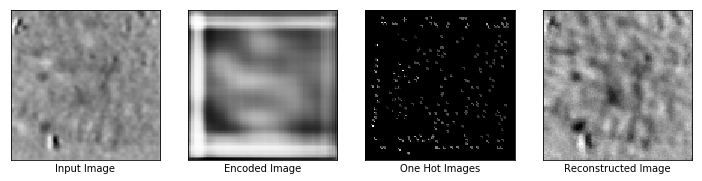

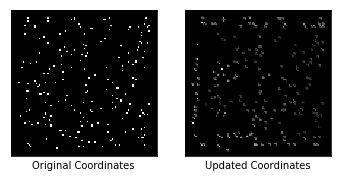

Epochs: 100, Reconstruction Loss: 0.0023944934364408255
Regularizer Loss: 46586.40234375, Total Loss: 46586.40625
Similarity Loss: 0.16506320238113403
Max Similarity scores: 0.9594523310661316
Updated Coordinates: [[[0.07670727 0.23393612]]]
Gradient global min:-0.00014519906835630536, max:0.00015524282935075462
Gradient encoder min:-0.044696077704429626, max:0.1233728900551796
Gradient learnable coords min:-0.00012528248771559447, max:0.00012649796553887427



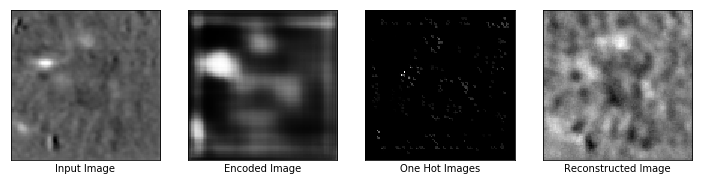

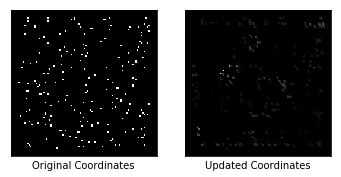

Epochs: 200, Reconstruction Loss: 0.001869508414529264
Regularizer Loss: 41026.34765625, Total Loss: 41026.34765625
Similarity Loss: 0.09872561693191528
Max Similarity scores: 0.8417136073112488
Updated Coordinates: [[[0.04495615 0.19974108]]]
Gradient global min:-0.0004828928504139185, max:0.0004984711413271725
Gradient encoder min:-0.024997809901833534, max:0.06276597827672958
Gradient learnable coords min:-0.00010954438039334491, max:0.00012273968604858965



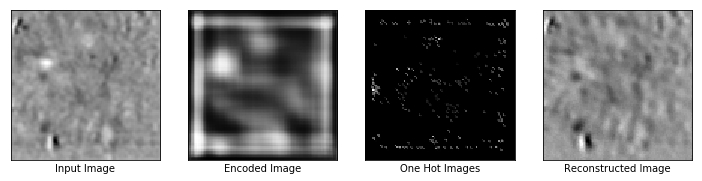

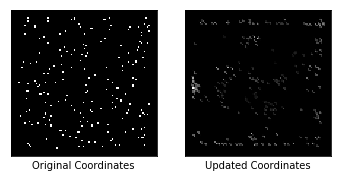

Epochs: 300, Reconstruction Loss: 0.0014792508445680141
Regularizer Loss: 36998.81640625, Total Loss: 36998.81640625
Similarity Loss: 0.06942866742610931
Max Similarity scores: 0.8935407996177673
Updated Coordinates: [[[0.06406489 0.23013645]]]
Gradient global min:-0.002103797160089016, max:0.0017353459261357784
Gradient encoder min:-0.02216201461851597, max:0.03965027257800102
Gradient learnable coords min:-8.348884148290381e-05, max:0.00014420451771002263



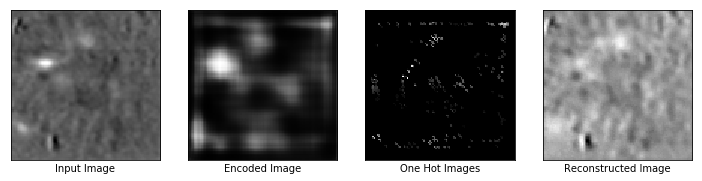

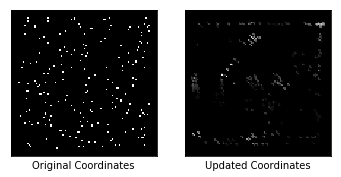

Epochs: 400, Reconstruction Loss: 0.0013457101304084063
Regularizer Loss: 38236.0390625, Total Loss: 38236.0390625
Similarity Loss: 0.06301110982894897
Max Similarity scores: 0.6697375178337097
Updated Coordinates: [[[0.07859104 0.23617256]]]
Gradient global min:-0.0008916156948544085, max:0.0006397002143785357
Gradient encoder min:-0.02998580038547516, max:0.03908985108137131
Gradient learnable coords min:-9.990137186832726e-05, max:0.00012340040120761842



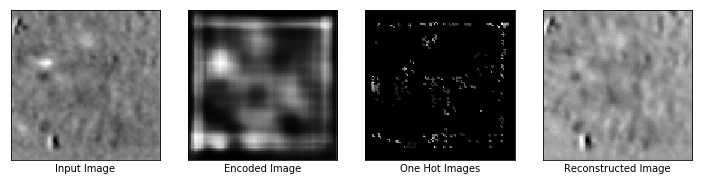

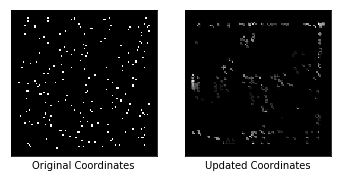

Epochs: 500, Reconstruction Loss: 0.0015093445545062423
Regularizer Loss: 38936.609375, Total Loss: 38936.609375
Similarity Loss: 0.053318317979574203
Max Similarity scores: 0.7695996761322021
Updated Coordinates: [[[0.07388877 0.22028333]]]
Gradient global min:-0.003237697761505842, max:0.0025687366724014282
Gradient encoder min:-0.030131764709949493, max:0.04386831820011139
Gradient learnable coords min:-6.288821168709546e-05, max:8.088962931651622e-05



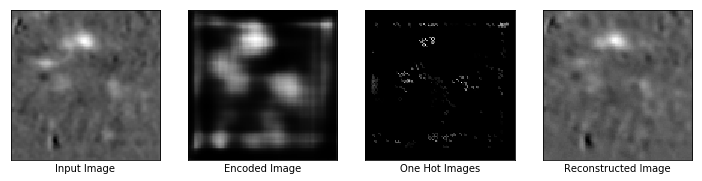

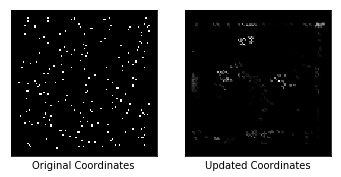

Epochs: 600, Reconstruction Loss: 0.0011979397386312485
Regularizer Loss: 42544.0703125, Total Loss: 42544.0703125
Similarity Loss: 0.05117219313979149
Max Similarity scores: 0.8604117035865784
Updated Coordinates: [[[0.05292319 0.28067064]]]
Gradient global min:-0.0007834782591089606, max:0.0006195587338879704
Gradient encoder min:-0.03369516879320145, max:0.05046936124563217
Gradient learnable coords min:-9.891857189359143e-05, max:6.791971100028604e-05



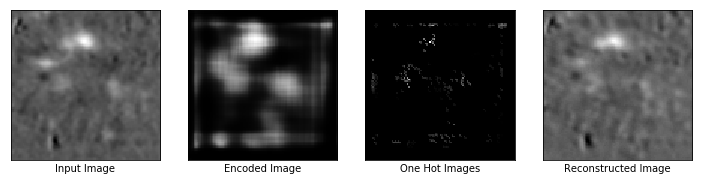

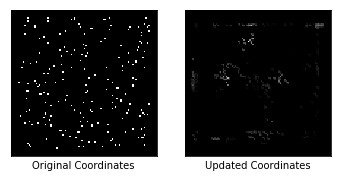

Epochs: 700, Reconstruction Loss: 0.001613130560144782
Regularizer Loss: 47016.390625, Total Loss: 47016.390625
Similarity Loss: 0.05166837200522423
Max Similarity scores: 0.8715932369232178
Updated Coordinates: [[[0.04924472 0.32986027]]]
Gradient global min:-0.0023262426257133484, max:0.0016697263345122337
Gradient encoder min:-0.03160903975367546, max:0.05357152596116066
Gradient learnable coords min:-0.0001241730060428381, max:8.823055395623669e-05



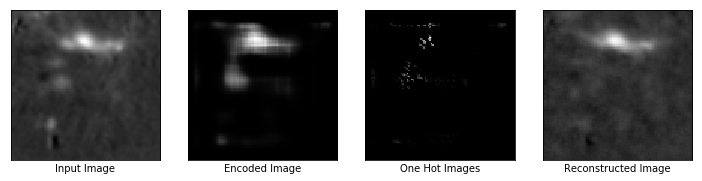

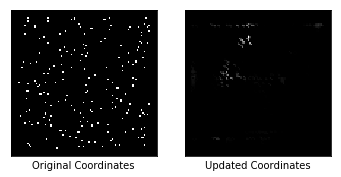

Epochs: 800, Reconstruction Loss: 0.0015248872805386782
Regularizer Loss: 56157.68359375, Total Loss: 56157.68359375
Similarity Loss: 0.029579943045973778
Max Similarity scores: 0.7542045712471008
Updated Coordinates: [[[0.05717701 0.35941383]]]
Gradient global min:-0.0032498331274837255, max:0.003485598834231496
Gradient encoder min:-0.02015986666083336, max:0.033214110881090164
Gradient learnable coords min:-8.487104787491262e-05, max:6.612942524952814e-05



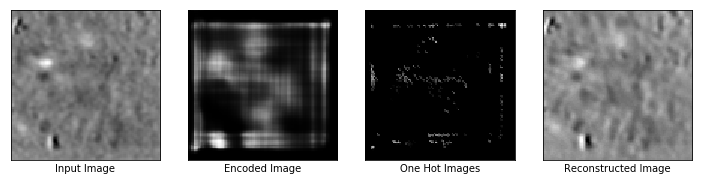

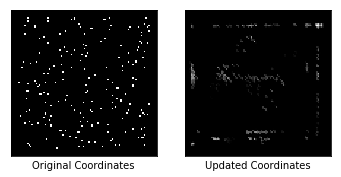

Epochs: 900, Reconstruction Loss: 0.0009704938856884837
Regularizer Loss: 71122.703125, Total Loss: 71122.703125
Similarity Loss: 0.029365569353103638
Max Similarity scores: 0.8234196305274963
Updated Coordinates: [[[0.04675216 0.3742794 ]]]
Gradient global min:-0.0008508680039085448, max:0.0007949573919177055
Gradient encoder min:-0.02160835824906826, max:0.03391352668404579
Gradient learnable coords min:-6.9597372203134e-05, max:9.783722634892911e-05



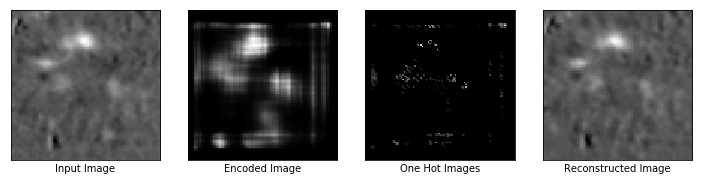

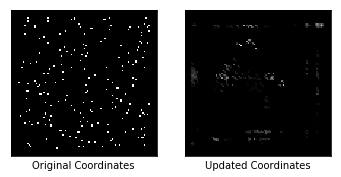

Epochs: 1000, Reconstruction Loss: 0.0009586986270733178
Regularizer Loss: 83698.7265625, Total Loss: 83698.7265625
Similarity Loss: 0.02813333086669445
Max Similarity scores: 0.7330990433692932
Updated Coordinates: [[[0.04877149 0.3681153 ]]]
Gradient global min:-0.000637398159597069, max:0.0004403801285661757
Gradient encoder min:-0.017641017213463783, max:0.02633967623114586
Gradient learnable coords min:-4.8360070650232956e-05, max:7.238145190058276e-05



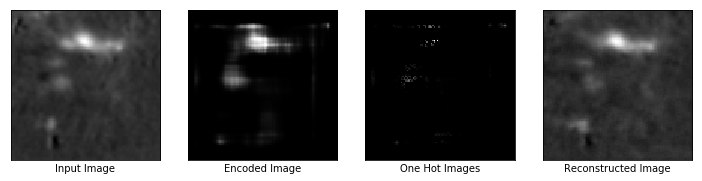

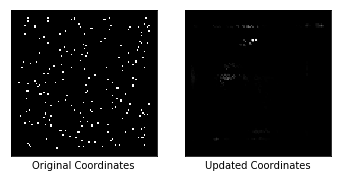

Epochs: 1100, Reconstruction Loss: 0.0009177001775242388
Regularizer Loss: 100208.1640625, Total Loss: 100208.1640625
Similarity Loss: 0.023570721969008446
Max Similarity scores: 0.8103410601615906
Updated Coordinates: [[[0.04769142 0.40983766]]]
Gradient global min:-0.0010762488236650825, max:0.0008212378597818315
Gradient encoder min:-0.016177551820874214, max:0.02240242250263691
Gradient learnable coords min:-0.00010118849604623392, max:8.96899655344896e-05



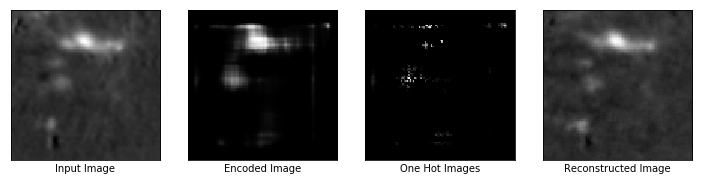

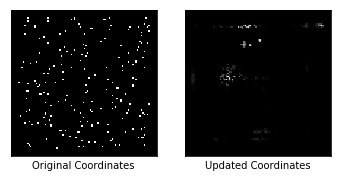

Epochs: 1200, Reconstruction Loss: 0.0008734418079257011
Regularizer Loss: 119066.640625, Total Loss: 119066.640625
Similarity Loss: 0.027658667415380478
Max Similarity scores: 0.815126895904541
Updated Coordinates: [[[0.04847537 0.4290983 ]]]
Gradient global min:-0.0006914418772794306, max:0.0006154723232612014
Gradient encoder min:-0.01942605711519718, max:0.02470111846923828
Gradient learnable coords min:-0.00010472217400092632, max:0.00014176619879435748



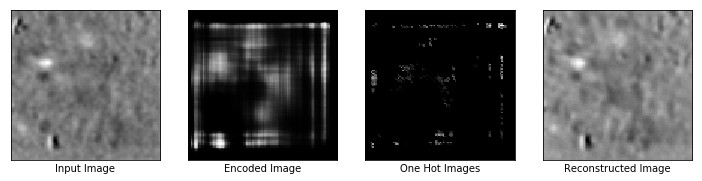

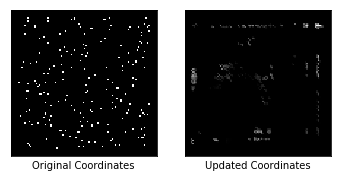

Epochs: 1300, Reconstruction Loss: 0.000893552612978965
Regularizer Loss: 136951.671875, Total Loss: 136951.671875
Similarity Loss: 0.02666032500565052
Max Similarity scores: 0.8941587209701538
Updated Coordinates: [[[0.05923905 0.4279987 ]]]
Gradient global min:-0.0006217907648533583, max:0.0005902093835175037
Gradient encoder min:-0.01978081651031971, max:0.024654287844896317
Gradient learnable coords min:-0.00011147217446705326, max:9.676018089521676e-05



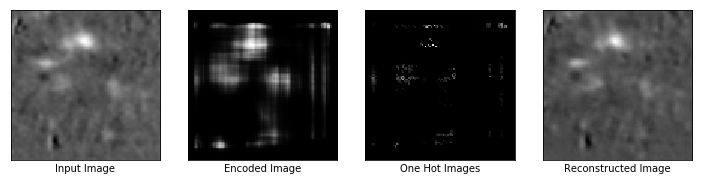

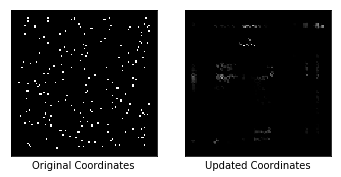

Epochs: 1400, Reconstruction Loss: 0.0008439603843726218
Regularizer Loss: 161857.859375, Total Loss: 161857.859375
Similarity Loss: 0.01975247450172901
Max Similarity scores: 0.8326109051704407
Updated Coordinates: [[[0.05084188 0.4309166 ]]]
Gradient global min:-0.0009064538171514869, max:0.0009359776158817112
Gradient encoder min:-0.016107682138681412, max:0.020594244822859764
Gradient learnable coords min:-0.00012464018072932959, max:9.907651110552251e-05



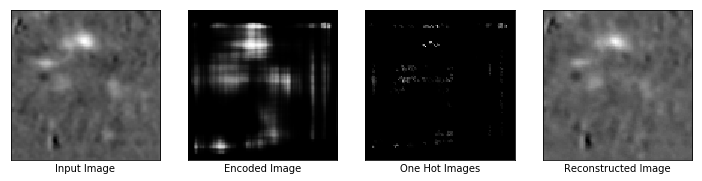

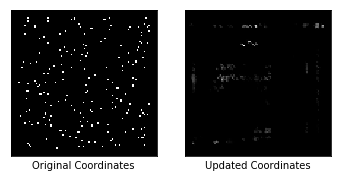

Epochs: 1500, Reconstruction Loss: 0.0013879125472158194
Regularizer Loss: 167225.875, Total Loss: 167225.875
Similarity Loss: 0.026492327451705933
Max Similarity scores: 0.8549515008926392
Updated Coordinates: [[[0.06021197 0.3699217 ]]]
Gradient global min:-0.0012930554803460836, max:0.0009477734565734863
Gradient encoder min:-0.01868533529341221, max:0.022599879652261734
Gradient learnable coords min:-0.00017902902618516237, max:0.0001732216915115714



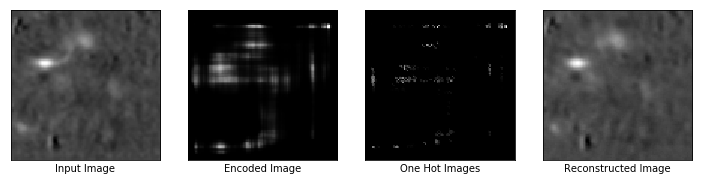

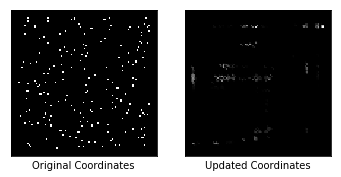

Epochs: 1600, Reconstruction Loss: 0.0006412672228179872
Regularizer Loss: 181998.875, Total Loss: 181998.875
Similarity Loss: 0.022014321759343147
Max Similarity scores: 0.7195736169815063
Updated Coordinates: [[[0.04763861 0.40279165]]]
Gradient global min:-0.0001027683392749168, max:0.0002175252593588084
Gradient encoder min:-0.018019026145339012, max:0.021775400266051292
Gradient learnable coords min:-0.00011016138887498528, max:0.0001555681519676



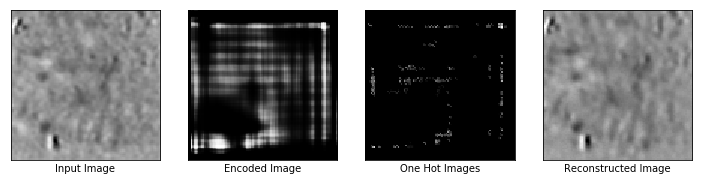

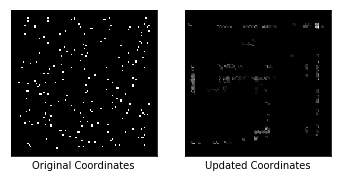

Epochs: 1700, Reconstruction Loss: 0.000653269118629396
Regularizer Loss: 192400.453125, Total Loss: 192400.453125
Similarity Loss: 0.023087164387106895
Max Similarity scores: 0.9691352248191833
Updated Coordinates: [[[0.04584106 0.44472858]]]
Gradient global min:-0.00030085843172855675, max:0.0006366589805111289
Gradient encoder min:-0.02058308757841587, max:0.022194722667336464
Gradient learnable coords min:-0.00015808136959094554, max:0.00011168878700118512



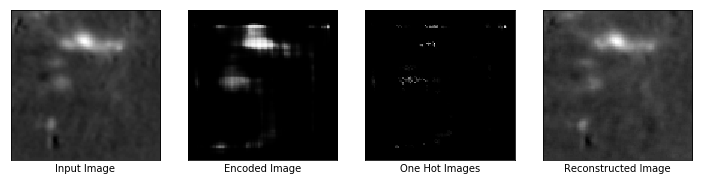

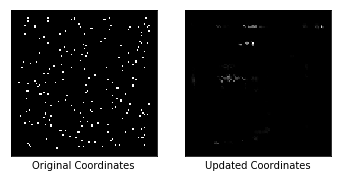

Epochs: 1800, Reconstruction Loss: 0.0006845900206826627
Regularizer Loss: 227527.984375, Total Loss: 227527.984375
Similarity Loss: 0.02608189731836319
Max Similarity scores: 0.9038882255554199
Updated Coordinates: [[[0.04201407 0.48128298]]]
Gradient global min:-0.0007689035846851766, max:0.0007067926344461739
Gradient encoder min:-0.02496180683374405, max:0.02601400576531887
Gradient learnable coords min:-9.187270188704133e-05, max:0.00012926067574881017



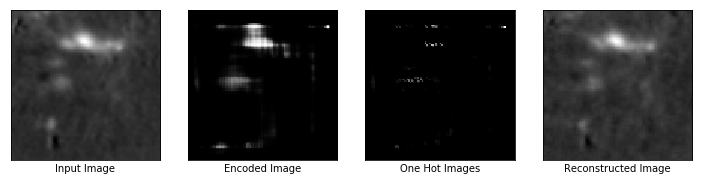

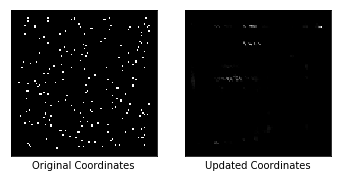

Epochs: 1900, Reconstruction Loss: 0.0006104884087108076
Regularizer Loss: 266135.8125, Total Loss: 266135.8125
Similarity Loss: 0.022649813443422318
Max Similarity scores: 0.9164111018180847
Updated Coordinates: [[[0.05651851 0.49239865]]]
Gradient global min:-0.0003100779140368104, max:0.000268582662101835
Gradient encoder min:-0.027580998837947845, max:0.027093280106782913
Gradient learnable coords min:-0.00018975882267113775, max:0.00015340767276939005



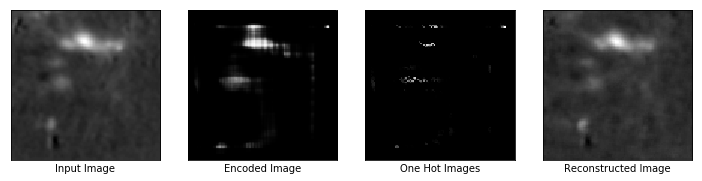

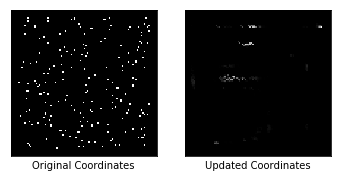

Epochs: 2000, Reconstruction Loss: 0.0008862914983183146
Regularizer Loss: 304842.9375, Total Loss: 304842.9375
Similarity Loss: 0.020007366314530373
Max Similarity scores: 0.884533703327179
Updated Coordinates: [[[0.05709648 0.48237887]]]
Gradient global min:-0.001762642990797758, max:0.0020513383205980062
Gradient encoder min:-0.02522282302379608, max:0.024336032569408417
Gradient learnable coords min:-0.00011849035217892379, max:0.0002009191521210596


In [12]:
batch_imgs= tf.data.Dataset.from_tensor_slices(re_list).batch(BATCH_SIZE, drop_remainder=True)

#list to be append to output 
loss_list_global = []
loss_list_encoded_one_hot = []
regulariser_loss_list = []
input_imgs = []
coords_list = []
encoded_imgs = []
reconstructed_imgs = []
one_hot_imgs_list = []
similarity_list = []

captions_01 = ['Input Image', 'Encoded Image', 'One Hot Images','Reconstructed Image']
captions_02 = ['Original Coordinates', 'Updated Coordinates']

#list to append to monitor each frames for the last epochs 
one_hot_imgs_last_list = []
encoder_output_last_list = []
similarity_score_last_list = []
reconstruction_last_list = []

epochs = 1
while epochs <= MAX_EPOCHS:
    #reset coords for each epochs
#     coords,_, ori_one_hot_imgs = create_dat_samples(n_neurons)
#     coords = tf.reshape(coords, [n_neurons, 1,1,2])
    for steps, batched_imgs in enumerate(batch_imgs):
        loss, updated_coords, one_hot_imgs, encoder_output, similarity_score, reconstruction, grad = train_fn(batched_imgs, coords, 
                                                                                                              IMG_SIZE, BATCH_SIZE,
                                                                                                             one_hot_thr = False)
        #append all frames for final epochs!
        if epochs==MAX_EPOCHS:
            one_hot_imgs_last_list.append(one_hot_imgs)
            encoder_output_last_list.append(encoder_output)
            similarity_score_last_list.append(similarity_score)
            reconstruction_last_list.append(reconstruction)
    #loss is append for each epochs
    loss_list_global.append(loss[0])
    loss_list_encoded_one_hot.append(loss[1])
    regulariser_loss_list.append(loss[-1])
    
    rand = randint(0, BATCH_SIZE-1) #random number to generate for plotting outputs 
    if epochs%100==0:
        img_row01 = [batched_imgs[rand], encoder_output[rand], similarity_multi(n_neurons, one_hot_imgs, similarity_score[rand], IMG_SIZE), reconstruction[rand]]
        img_row02 = [stack4plot(ori_one_hot_imgs), similarity_multi(n_neurons, one_hot_imgs, similarity_score[rand], IMG_SIZE)]
        plot_comparison(img_row01, captions_01, n_col=len(img_row01), figsize = (10, 10))
        plot_comparison(img_row02, captions_02, n_col=len(img_row02))
        print("Epochs: {}, Reconstruction Loss: {}".format(epochs, loss[0].numpy()))
        print("Regularizer Loss: {}, Total Loss: {}".format(loss[-1].numpy(), loss[0].numpy()+loss[-1].numpy()))
        print("Similarity Loss: {}".format(loss[1].numpy()))
        print("Max Similarity scores: {}".format(np.max(similarity_score[rand])))
        print("Updated Coordinates: {}".format(updated_coords[0]))
        print("Gradient global min:{}, max:{}".format(np.min(grad[0][rand]), np.max(grad[0][rand])))
        print("Gradient encoder min:{}, max:{}".format(np.min(grad[1][0]), np.max(grad[1][0])))
        print("Gradient learnable coords min:{}, max:{}".format(np.min(grad[2][0]), np.max(grad[2][0])))
        #append to list 
        encoded_imgs.append(encoder_output)
        input_imgs.append(batched_imgs)
        coords_list.append(updated_coords)
        reconstructed_imgs.append(reconstruction)
        one_hot_imgs_list.append(one_hot_imgs)
        similarity_list.append(similarity_score)
        
    epochs+=1

----

# Save Output Data

In [13]:
save_list = [loss_list_global, loss_list_encoded_one_hot, input_imgs, coords_list, encoded_imgs, reconstructed_imgs, one_hot_imgs_list, similarity_list]
save_names = ['loss_list_global', 'loss_list_encoded_one_hot', 'input_imgs', 'coords_list', 'encoded_imgs', 'reconstructed_imgs', 'one_hot_imgs_list', 'similarity_list']

directory = '/home/kevinteng/Desktop/npy/{}'.format(ver)
#make directory to save
if not os.path.exists(directory):
    os.makedirs(directory)
    
for names, items in zip(save_names, save_list):
    tensor = tf.convert_to_tensor(items, tf.float32)
    np.save(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, names, ver), np.array(tensor))
    

In [14]:
#save coords and one hot images()
np.save(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'ori_coords', ver), np.array(coords))
np.save(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'ori_one_hot_imgs', ver), np.array(ori_one_hot_imgs))

In [15]:
#save info for every frames in last epochs
save_list_last = [encoder_output_last_list, similarity_score_last_list, reconstruction_last_list]
save_names_last = ['encoder_output_last_list', 'similarity_score_last_list', 'reconstruction_last_list']

for names, items in zip(save_names_last, save_list_last):
    aggregate_tensor = utils.concat_batch(items)
    np.save(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, names, ver), np.array(aggregate_tensor))

In [16]:
#save one hot imgs for last epochs 
tensor = tf.convert_to_tensor(one_hot_imgs_last_list, tf.float32) #(frames/batch, n_neurons, img_size, img_size, 1)
np.save(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'one_hot_imgs_last_list', ver), np.array(tensor))

In [17]:
#save weights
encoder_model.save_weights('model_weights/encoder_model_{}.h5'.format(ver))
decoder_model.save_weights('model_weights/decoder_model_{}.h5'.format(ver))

---

# Visualization

In [18]:
# coords list for every 100 epochs (max_epochs/100, n_neurons, 1, 1, 2)
coords_list_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'coords_list', ver)) 
# encoder output first batch for every 100 epochs (max_epochs/100, 8, 100, 100, 1)
encoded_imgs_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'encoded_imgs', ver))
# input image first batch for every 100 epochs (max_epochs/100, 8, 100, 100, 1)
input_imgs_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'input_imgs', ver))
# global loss for every epochs
loss_list_global_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'loss_list_global', ver))
#similarity loss for every epochs
loss_list_encoded_one_hot_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'loss_list_encoded_one_hot', ver))
# one hot images first batch for every 100 epochs  (max_epochs/100, n_neurons, 100, 100, 1)
one_hot_imgs_list_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'one_hot_imgs_list', ver))
# reconstructed images first batch for every 100 epochs (max_epochs/100, 8, 100, 100, 1)
reconstructed_imgs_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'reconstructed_imgs', ver))
# similarity batch for every 100 epochs (max_epochs/100, 8, n_neurons)
similarity_list_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'similarity_list', ver))
#original coords list (n_neurons, 1, 1, 2)
ori_coords_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'ori_coords', ver))
#original one hot image (n_neurons, 100, 100, 1)
ori_one_hot_imgs_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'ori_one_hot_imgs', ver))

In [19]:
#load roi mask
roi_img = np.load('/home/kevinteng/Desktop/Manual_annotation/DG-13-3-8-17_ROImask.npy')
roi_img = cv2.resize(roi_img, (100, 100))
# plt.imshow(roi_img, cmap = 'gray')

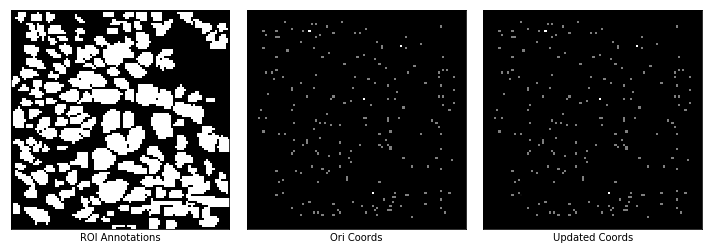

In [20]:
#comparison of roi and one hot images 
captions_03 = ['ROI Annotations', 'Ori Coords', 'Updated Coords']
img_row03 = [roi_img, stack4plot(ori_one_hot_imgs_npy), stack4plot(one_hot_imgs_list_npy[-1])]
plot_comparison(img_row03, captions_03, n_col=len(img_row03), figsize = (10, 10))

Mean value:  0.020000001
Counts:  196


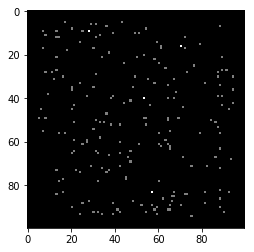

In [21]:
sum_updated_coords = stack4plot(one_hot_imgs_list_npy[-1])
print("Mean value: ", np.mean(sum_updated_coords))
updated_coords_img = np.where(sum_updated_coords<0.1, 0, sum_updated_coords) 
activations_count = np.count_nonzero(updated_coords_img!=0)
print("Counts: ", activations_count)
plt.imshow(updated_coords_img, cmap = 'gray')

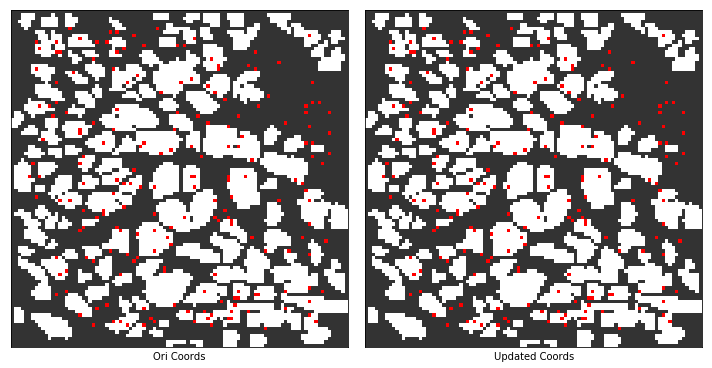

In [22]:
#define color
col = [(0.2, 0.2, 0.2),(1,1,1),(1,0,0)] 
cm = LinearSegmentedColormap.from_list('mylist', col, 3)  
#     #Bins for cmap
bounds=[0,1,5,10]
norm = BoundaryNorm(bounds, cm.N)
#overlap mask with original coordinates 
roi_ori_mask = overlapMasks02(roi_img, stack4plot(ori_one_hot_imgs_npy))

#overlap mask with updated coordinates 
roi_updated_mask = overlapMasks02(roi_img, updated_coords_img)

captions_04 = ['Ori Coords', 'Updated Coords']
img_row04 = [roi_ori_mask, roi_updated_mask]
plot_comparison(img_row04, captions_04, n_col=len(img_row04), figsize = (10, 10), cmap = cm, norm = norm)

In [23]:
#confusion matrix 
confMatrix = utils_model.getConfusionMatrix(roi_img, updated_coords_img)

print("True Positives: ", confMatrix[0])
print("True Negatives: ", confMatrix[1])
print("False Positive Ratio: ", confMatrix[2])
print("False Negatives Ratio: ", confMatrix[3])
print("F1 score: ", utils_model.f1score(confMatrix))

True Positives:  0.0102
True Negatives:  0.0094
False Positive Ratio:  0.4084
False Negatives Ratio:  0.5720000000000001
F1 score:  0.04655408489274305


---

# Similarity Scores with Threshold

In [26]:
neuron_activations, neuron_activations_thr = similarity_multiplication(similarity_list_npy, one_hot_imgs_list_npy, 
                                                                       n_neurons, epoch_pos=-1, 
                                                                       img_size = IMG_SIZE, threshold = 0.7)

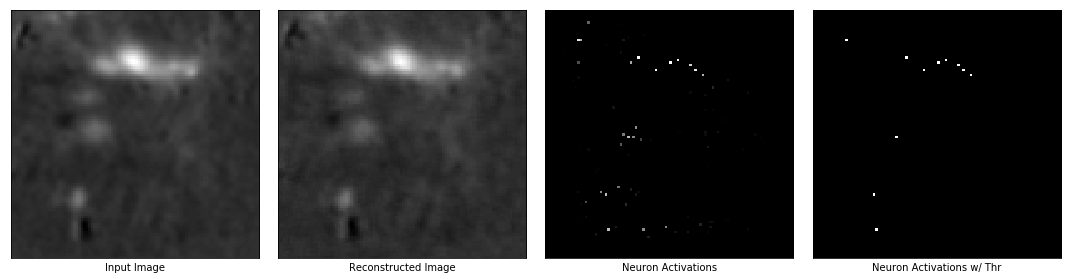

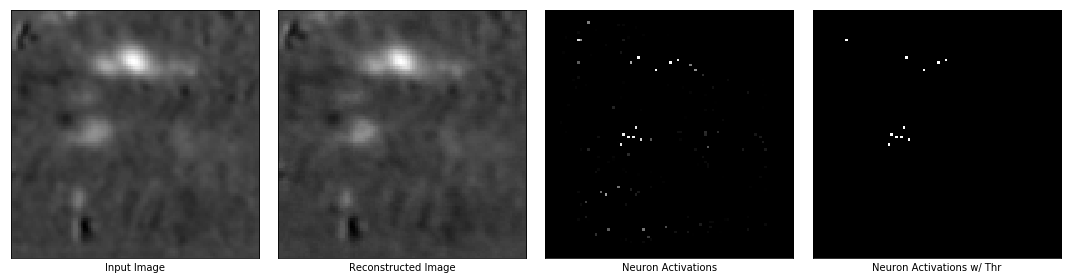

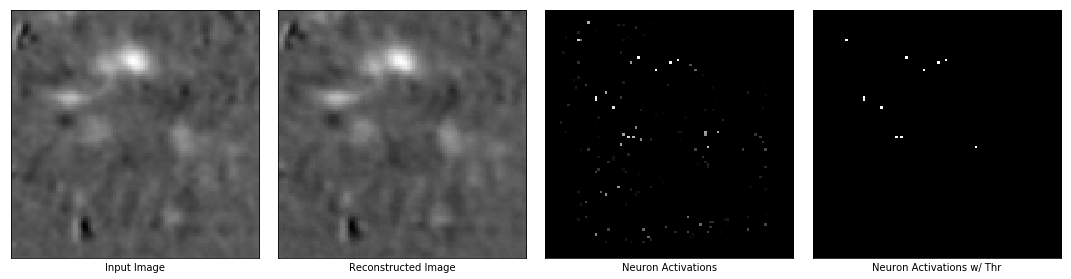

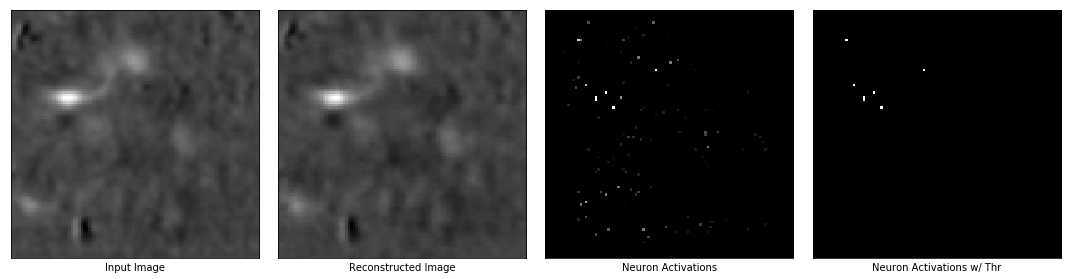

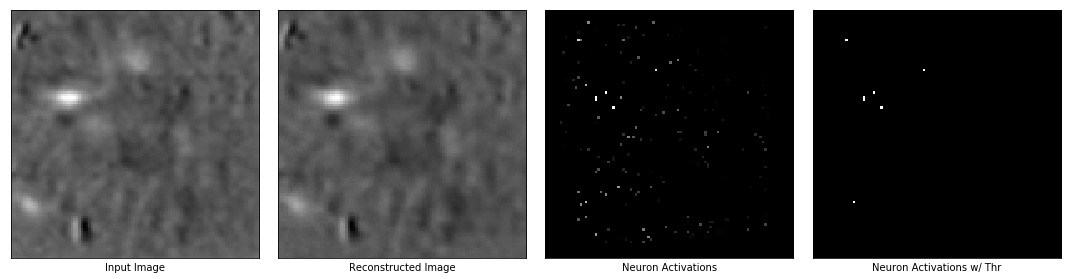

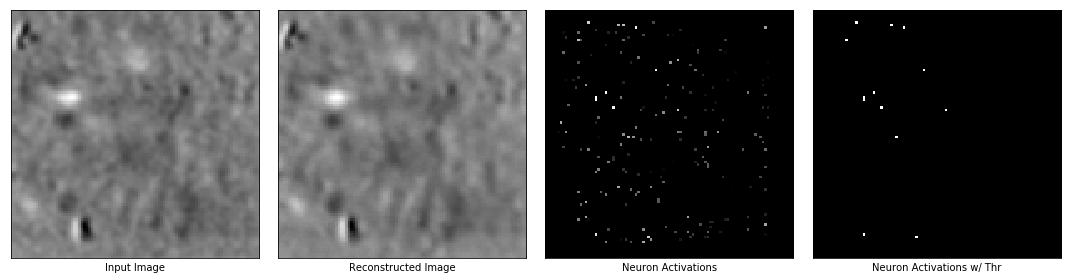

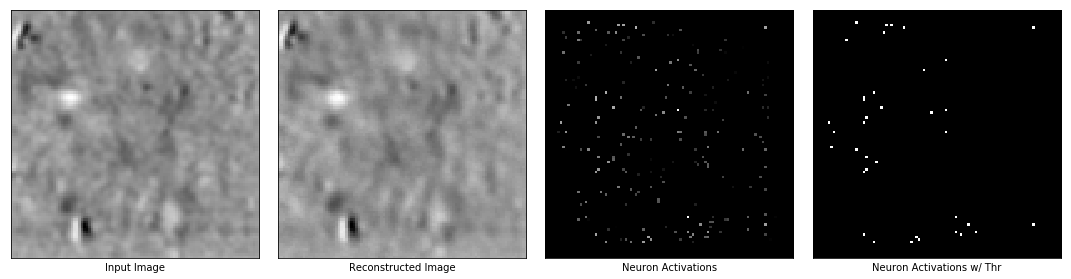

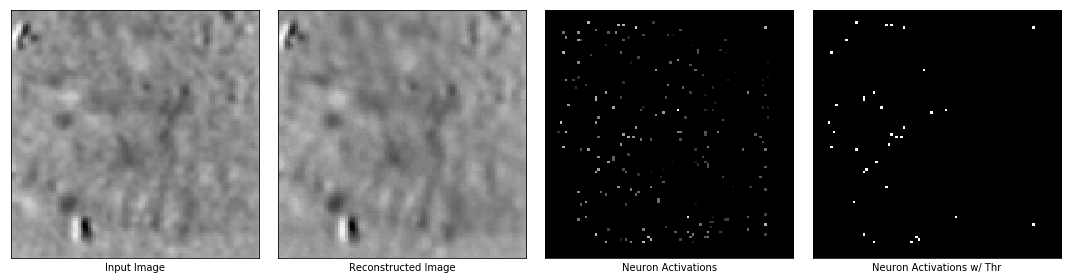

In [27]:
batch_size = BATCH_SIZE
captions_03 = ['Input Image', 'Reconstructed Image','Neuron Activations', 'Neuron Activations w/ Thr']
for i in range(batch_size):
    img_row03 = [np.squeeze(input_imgs_npy[-1,i]), np.squeeze(reconstructed_imgs_npy[-1,i]), neuron_activations[i], neuron_activations_thr[i]]
    plot_comparison(img_row03, captions_03, n_col=len(img_row03), figsize = (15, 15))

## Loss Plot

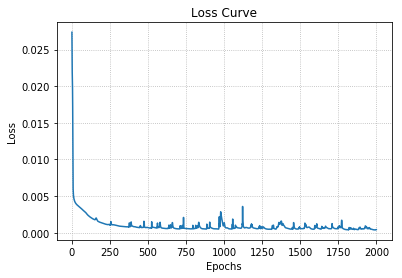

In [28]:
#plot loss
xlabel = 'Epochs'
ylabel = 'Loss'
title = 'Loss Curve'
utils_vis.plot_loss(loss_list_global_npy, xlabel, ylabel, title)

## Feature Maps

In [29]:
#build encoder 
inps = Input(shape=(IMG_SIZE, IMG_SIZE, 1))
encoder_model = Model(inps, encoder(inps, IMG_SIZE))
encoder_model.load_weights("model_weights/encoder_model_{}.h5".format(ver))
#build coord model
inp = Input(shape=(100, 100,2)) #(batch_size, img_size, img_size, 2)
de_coordconv = Model(inp, de_conv(inp))
de_coordconv.load_weights("best_class_model100_02.hdf5")

#decoder
latent_dim = Input(shape=(n_neurons, 3, 1))
decoder_model = Model(latent_dim, decoder(latent_dim))
decoder_model.load_weights("model_weights/decoder_model_{}.h5".format(ver))

#learnable coords
l_coords = learnable_coords(ori_coords_npy)

In [30]:
decoder_layers_name = utils_vis.layers_name(decoder_model) 

input_6
flatten_3
dense_1
reshape_1
up_sampling2d_8
coord_conv_9
activation_2
up_sampling2d_9
conv2d_36
activation_3
conv2d_37


In [31]:
#concat latent space as input
squeeze_coords = np.squeeze(coords_list_npy[-1]) #use the last pos
similarity_score = similarity_list_npy[-1]


concat = tf.stack((squeeze_coords[:,-2], squeeze_coords[:,-1], similarity_score[0]), axis=-1)
concat_ex = concat[np.newaxis,:,:,np.newaxis] #extand axis=0 and axis=-1 for input into model
print(concat_ex.shape)

(1, 200, 3, 1)


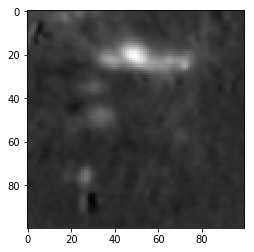

In [32]:
plt.imshow(np.squeeze(input_imgs_npy[-1,0]), cmap = 'gray')

Shape of feature maps: (1, 50, 50, 64)
Number of feature maps in layer:  64


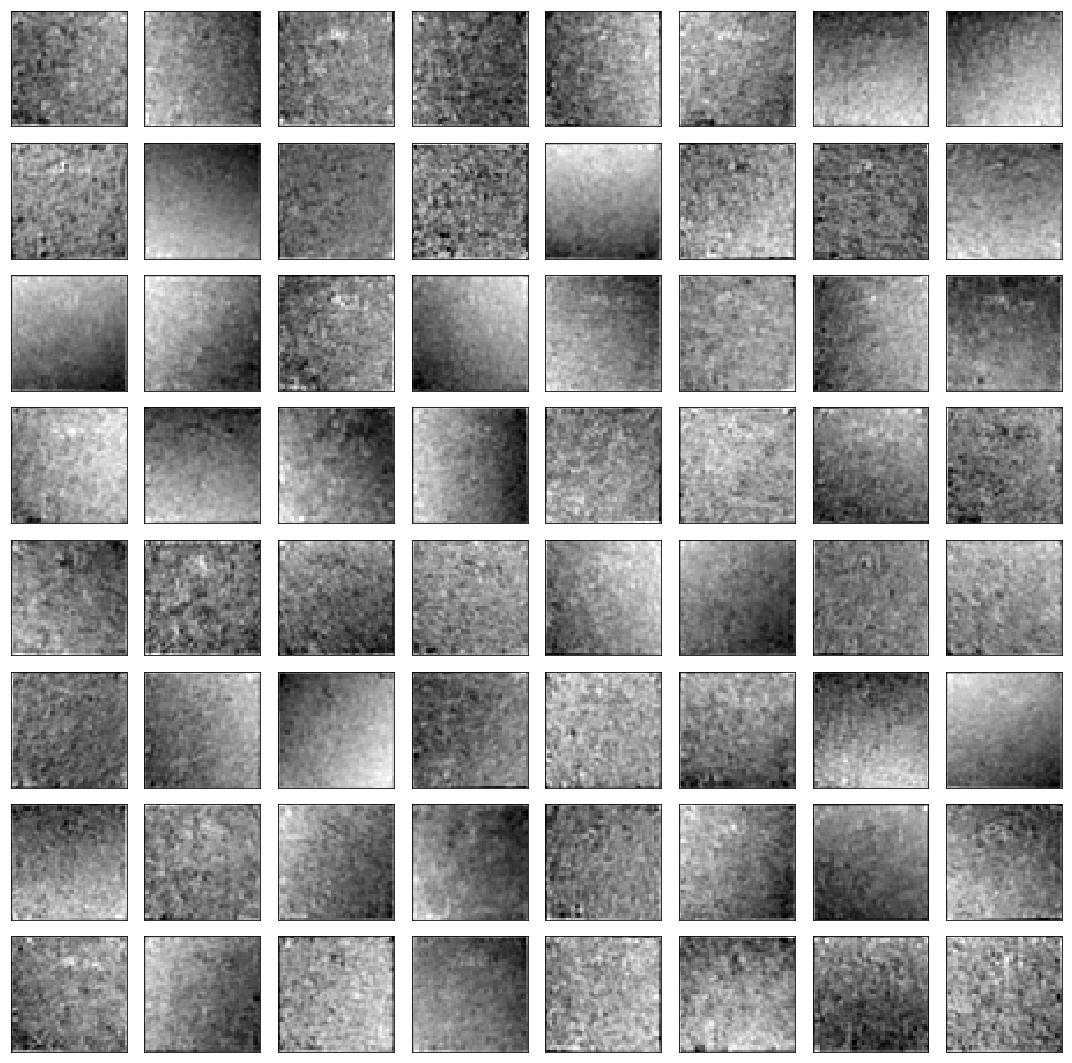

In [33]:
coord_conv_feature_maps = utils_vis.feature_maps(decoder_model, 'coord_conv_9', concat_ex)
utils_vis.plot_feature_maps(coord_conv_feature_maps, 8, 8, figsize=(15,15))

Shape of feature maps: (1, 100, 100, 32)
Number of feature maps in layer:  32


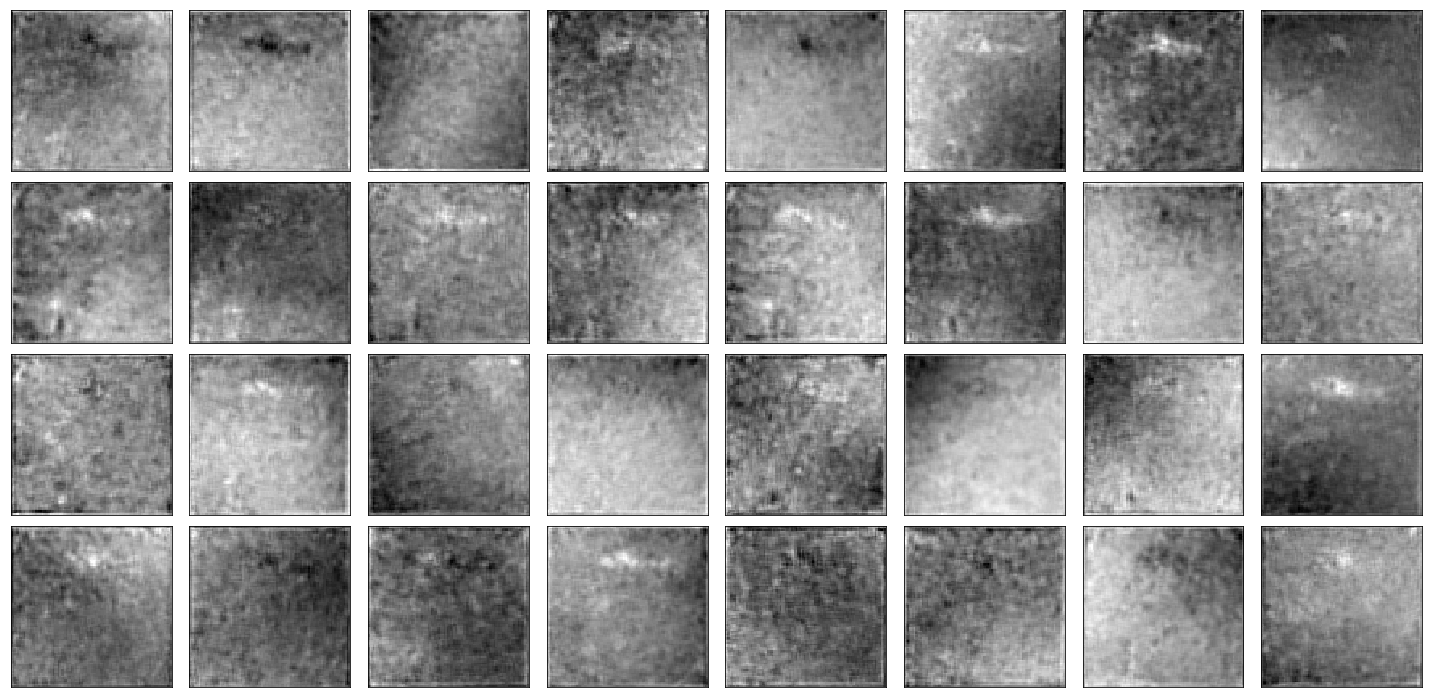

In [34]:
coord_conv_feature_maps = utils_vis.feature_maps(decoder_model, 'conv2d_36', concat_ex)
utils_vis.plot_feature_maps(coord_conv_feature_maps, 4, 8, figsize=(20,10))

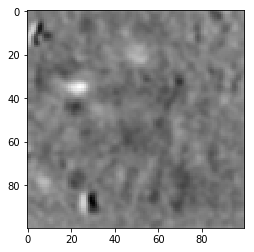

In [35]:
plt.imshow(np.squeeze(input_imgs_npy[-1,5]), cmap = 'gray')

In [36]:
#concat latent space as input
squeeze_coords = np.squeeze(coords_list_npy[-1]) #use the last pos
similarity_score = similarity_list_npy[-1]


concat = tf.stack((squeeze_coords[:,-2], squeeze_coords[:,-1], similarity_score[5]), axis=-1)
concat_ex = concat[np.newaxis,:,:,np.newaxis] #extand axis=0 and axis=-1 for input into model
print(concat_ex.shape)

(1, 200, 3, 1)


Shape of feature maps: (1, 50, 50, 64)
Number of feature maps in layer:  64


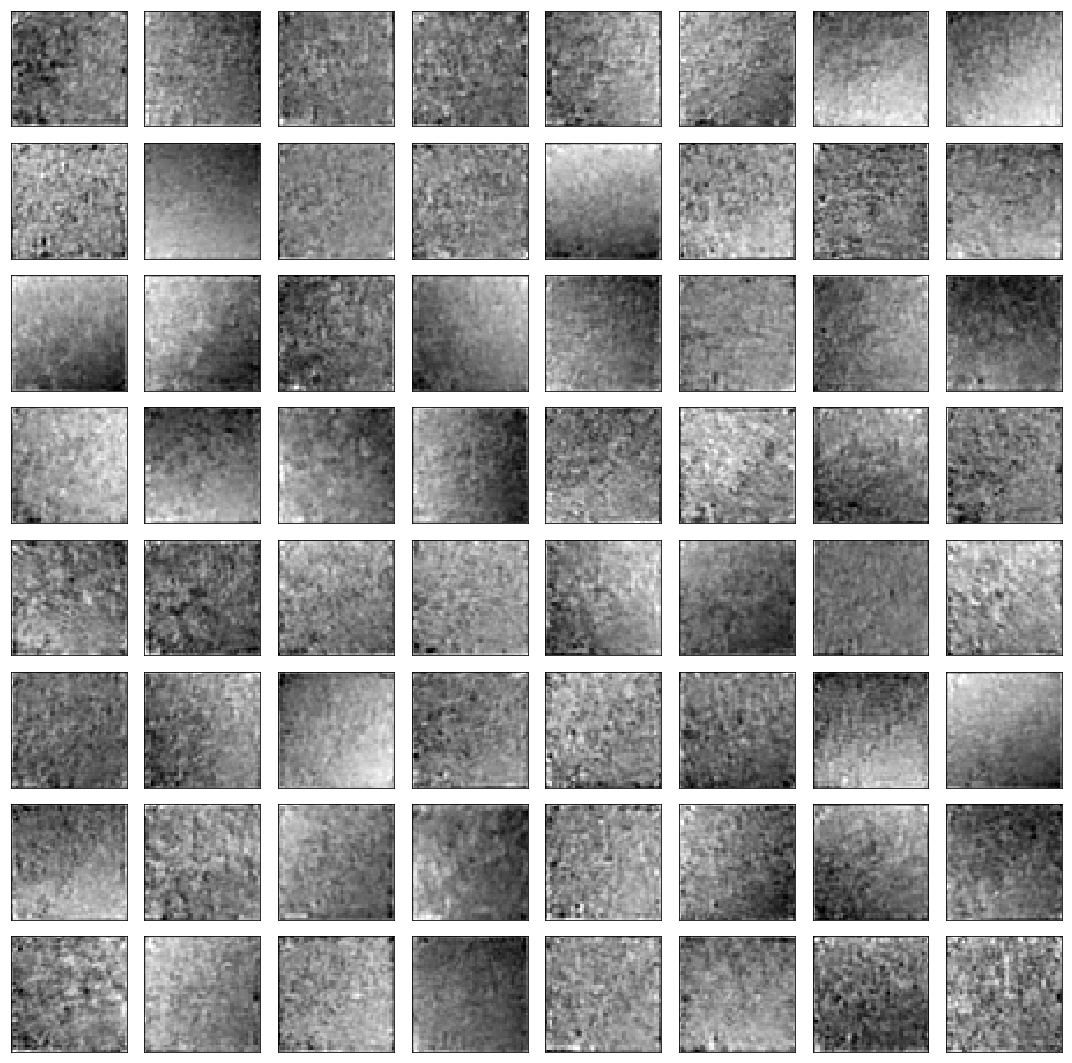

In [37]:
coord_conv_feature_maps = utils_vis.feature_maps(decoder_model, 'coord_conv_9', concat_ex)
utils_vis.plot_feature_maps(coord_conv_feature_maps, 8, 8, figsize=(15,15))

Shape of feature maps: (1, 100, 100, 32)
Number of feature maps in layer:  32


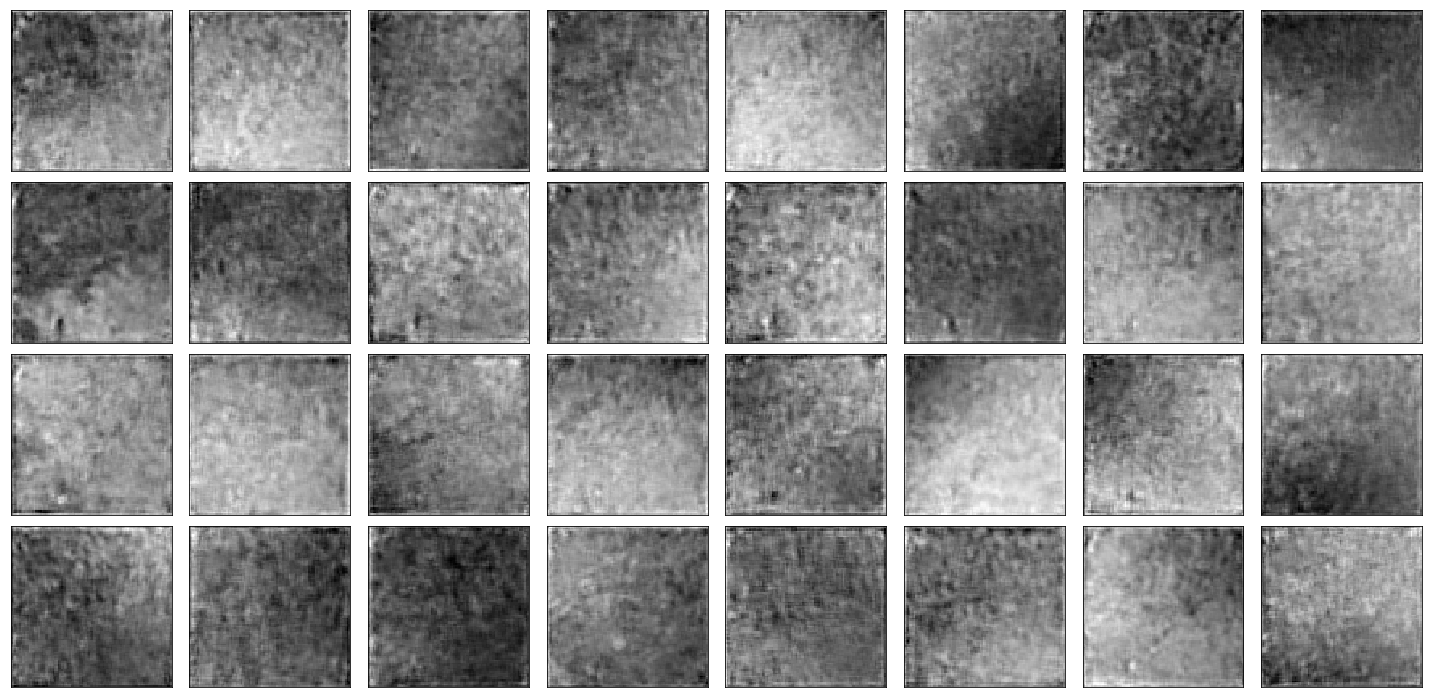

In [38]:
coord_conv_feature_maps = utils_vis.feature_maps(decoder_model, 'conv2d_36', concat_ex)
utils_vis.plot_feature_maps(coord_conv_feature_maps, 4, 8, figsize=(20,10))

---

# Visualization Per-frame

In [39]:
one_hot_imgs_last_list_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'one_hot_imgs_last_list', ver))
encoder_output_last_list_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'encoder_output_last_list', ver))
similarity_score_last_list_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'similarity_score_last_list', ver))
reconstruction_last_list_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'reconstruction_last_list', ver))

In [40]:

def multi_similarity_frame(one_hot_imgs_last_list_npy, similarity_score_last_list_npy, img_size, batch_size):
    '''
    Multiply similarity scores for every one hot pixel images and aggregate the one hot images into
    single frames
    
    @param one_hot_imgs_last_list_npy: .npy array of one hot images for the last epochs 
    @param similarity_score_last_list_npy: .npy array of similarity score for the last epochs
    @param img_size: image size
    @param batch_size: batch size
    
    return 
    tensor of one hot images multiplied with similarity scores for each images 
    '''
    count = 0
    onehot_list = []
    for one_hot in np.squeeze(one_hot_imgs_last_list_npy):
        if count!=len(similarity_score_last_list_npy): 
            for idx in range(count,count+batch_size): #loop through the similarity score for every batch_size increment
                sum_multi = np.zeros((img_size, img_size))
                for n in range(len(one_hot)): #n_neurons
                    multi = similarity_score_last_list_npy[idx, n]*one_hot[n]
                    sum_multi+=multi #sum all the one hot images
                onehot_list.append(sum_multi)
        count+=batch_size
        tensor = tf.convert_to_tensor(onehot_list, tf.float32)
    
    return tensor

In [41]:
tensor = multi_similarity_frame(one_hot_imgs_last_list_npy, similarity_score_last_list_npy, IMG_SIZE, BATCH_SIZE)

## Maximum Intensity Projection

In [96]:
# plt_captions = ['Original Coordinates', 'Maximum Intensity Projection']
# plt_row = [stack4plot(ori_one_hot_imgs_npy), np.where(np.sum(tensor, axis=0)<0.8, 0, 1.0)]

# plot_comparison(plt_row , plt_captions, n_col=len(plt_row), figsize = (15, 15))

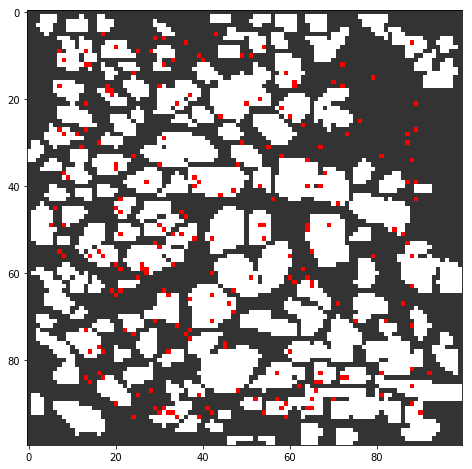

In [42]:
#define color
col = [(0.2, 0.2, 0.2),(1,1,1),(1,0,0)] 
cm = LinearSegmentedColormap.from_list('mylist', col, 3)  
#     #Bins for cmap
bounds=[0,1,5,10]
norm = BoundaryNorm(bounds, cm.N)

plt.figure(figsize=(8,8))
tensor_sum02 = np.where(np.sum(tensor, axis=0)<0.8, 0, 1.0)
roi_frame = overlapMasks02(roi_img, tensor_sum02)
plt.imshow(roi_frame, cmap = cm , norm = norm)
plt.show()

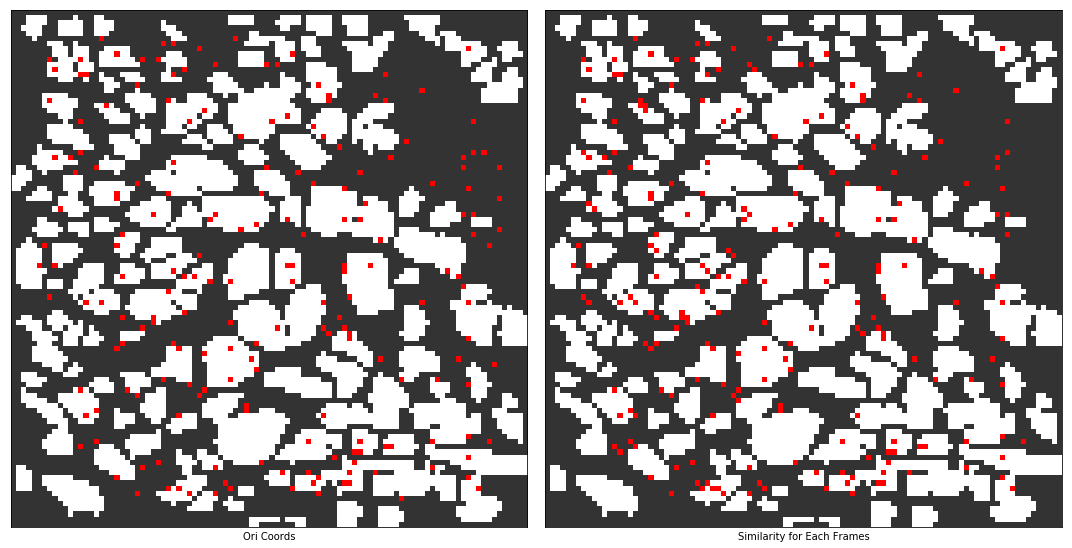

Counts:  213


In [43]:
#overlap mask with original coordinates 
roi_ori_mask = overlapMasks02(roi_img, stack4plot(ori_one_hot_imgs_npy))

captions_05 = ['Ori Coords', 'Similarity for Each Frames']
img_row05 = [roi_ori_mask, roi_frame]
plot_comparison(img_row05, captions_05, n_col=len(img_row05), figsize = (15, 15), cmap = cm, norm = norm)

activations_count = np.count_nonzero(tensor_sum02!=0)
print("Counts: ", activations_count)